## Wine Reviews Analysis: 
### What countries are the major producers of the wine and what sorts of wine have the best rating in those countries?###
### What are the best rated wines in the different price category?###
### What is the most common description for the best rated wines produced in different countries?###



In [1]:
#import libraries here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import re
from PIL import Image
from sklearn import preprocessing

%matplotlib inline

In [2]:
#read data to DataFrame
wine_main = pd.read_csv('winemag-data-130k-v2.csv')

#shape
print("Number of reviews:", wine_main.shape[0])
print("Number of columns:", wine_main.shape[1])
print("total number of countries: ", len(wine_main["country"].value_counts()))

wine_main.head()


Number of reviews: 129971
Number of columns: 14
total number of countries:  43


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


region_2                 61.14
designation              28.83
taster_twitter_handle    24.02
taster_name              20.19
region_1                 16.35
price                     6.92
province                  0.05
country                   0.05
variety                   0.00
winery                    0.00
title                     0.00
points                    0.00
description               0.00
Unnamed: 0                0.00
dtype: float64

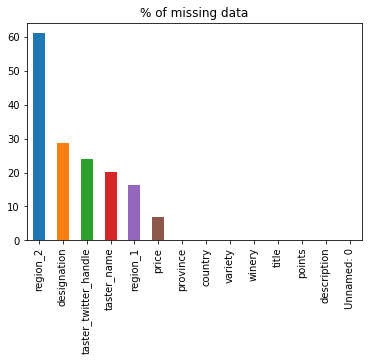

In [3]:
#identify missing data by column
missing_by_columns = wine_main.isnull().mean().sort_values(ascending=False).round(4)*100
missing_by_columns.plot(kind='bar')
plt.title("% of missing data")
missing_by_columns

Among the columns with the most missing values are region_2 (%61), designation (%29), taster_twitter_handle (%24) and taster_name (%20). I decided to drop this column. The missing values in region_1 can simply mean that there is no region which can give important information.

In [4]:
#drop region_2, designation, taster_twitter_handle, taster_name
wine_clmn_reduced = wine_main.drop(columns=["region_2", "designation", "taster_twitter_handle", "taster_name"])
wine_clmn_reduced.head()

,Unnamed: 0,country,description,points,price,province,region_1,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
#missing by rows
#drop rows with missing price
#Since country is one of the most important attribute to predict price. We will drop 59 rows with missing country. 
wine_row_reduced = wine_clmn_reduced.dropna(subset=['country','variety', 'price'], how='any')
#check missing values by column again
print("Number of rows, columns:", (wine_row_reduced.shape[0], wine_row_reduced.shape[1]))
wine_row_reduced.isnull().sum().sort_values(ascending=False)


Number of rows, columns: (120915, 10)


region_1       19515
winery             0
variety            0
title              0
province           0
price              0
points             0
description        0
country            0
Unnamed: 0         0
dtype: int64

I will group wines by title: take mean value for the price and points, take the first entry for country, province, region_1, variety and winery (because all this attributes supposed to be the same for given title), and I will joint descriptions together making a list of available reviews for given wine.

In [6]:
#Lets group by wines by title
wine_groupped = wine_row_reduced.groupby('title').agg(dict(country = 'first', description = list, points = 'mean', price = 'mean', province='first', region_1 = 'first', variety = 'first', winery = 'first')).reset_index()
wine_groupped

,title,country,description,points,price,province,region_1,variety,winery
0,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),Spain,[The previous two years we did not find this w...,82.0,18.0,Catalonia,Penedès,Cabernet Sauvignon,1+1=3
1,1+1=3 NV Brut Sparkling (Cava),Spain,[Spiced apple and toast aromas are clean and d...,87.0,16.0,Catalonia,Cava,Sparkling Blend,1+1=3
2,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Spain,"[Clean, fresh apple aromas and a minerally, ci...",89.0,20.0,Catalonia,Cava,Sparkling Blend,1+1=3
3,1+1=3 NV Rosé Sparkling (Cava),Spain,"[A dusty, yeasty nose is simplistic but friend...",86.0,20.0,Catalonia,Cava,Sparkling Blend,1+1=3
4,10 Knots 2006 Beachcomber White (Paso Robles),US,"[A Rhône blend of Viognier, Roussanne and Mars...",83.0,21.0,California,Paso Robles,Rhône-style White Blend,10 Knots
5,10 Knots 2006 Chardonnay (Santa Barbara County),US,[Oaky influences give this wine a candied tast...,85.0,21.0,California,Santa Barbara County,Chardonnay,10 Knots
6,10 Knots 2009 Moonraker Grenache (Paso Robles),US,"[Hot in alcohol, simple in everything else, th...",81.0,35.0,California,Paso Robles,Grenache,10 Knots
7,10 Knots 2010 Viognier (Paso Robles),US,"[A strongly flavored, sugary, unsubtle wine, l...",84.0,22.0,California,Paso Robles,Viognier,10 Knots
8,100 Percent Wine 2012 All Profits to Charity R...,US,"[Juicy and fresh, this deeply colored wine off...",89.0,18.0,California,California,Red Blend,100 Percent Wine
9,100 Percent Wine 2014 All Profits to Charity S...,US,"[Herbaceous in aroma, dry and lean on the pala...",84.0,18.0,California,California,Sauvignon Blanc,100 Percent Wine




### 1. What countries are the major producers of the wine and what sorts of wine have the best rating in those countries?###

In [7]:
countries_wine_counts = wine_groupped['country'].value_counts(ascending=False)
print("total number of countries: ", len(countries_wine_counts))
countries_wine_counts

total number of countries:  42


US                        50012
France                    15817
Italy                     15407
Spain                      5954
Portugal                   4475
Chile                      4123
Argentina                  3500
Austria                    2527
Australia                  2155
Germany                    1949
New Zealand                1238
South Africa               1195
Israel                      453
Greece                      424
Canada                      224
Bulgaria                    132
Hungary                     128
Romania                     101
Uruguay                      98
Turkey                       80
Georgia                      74
Slovenia                     70
Croatia                      68
Mexico                       68
England                      59
Moldova                      56
Brazil                       44
Lebanon                      32
Morocco                      24
Peru                         16
Ukraine                      14
Macedoni

We will create barplot of major wine producers that produce more than 1000 different wines

Major wine producers: Index(['US', 'France', 'Italy', 'Spain', 'Portugal', 'Chile', 'Argentina',
       'Austria', 'Australia', 'Germany', 'New Zealand', 'South Africa'],
      dtype='object')


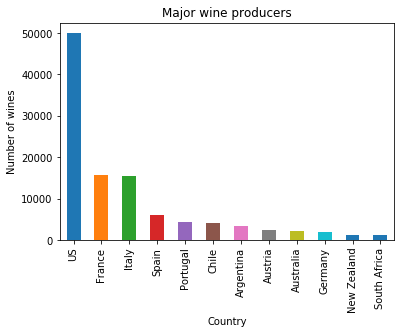

In [8]:
countries_wine_counts[:12].plot(kind='bar')
plt.title("Major wine producers")
plt.ylabel("Number of wines")
plt.xlabel("Country")
major_countries = countries_wine_counts[:12].index
print("Major wine producers:", major_countries)


In [9]:
wine_groupped['counts'] = 0
country_variety_counts =  wine_groupped.groupby(['country', 'variety']).agg(dict(counts = 'count', points = 'median')).sort_values(by='counts', ascending=False).reset_index()
country_variety_counts[:10]

,country,variety,counts,points
0,US,Pinot Noir,9121,90.0
1,US,Cabernet Sauvignon,6780,89.0
2,US,Chardonnay,6235,88.0
3,US,Syrah,2998,90.0
4,Italy,Red Blend,2996,89.0
5,France,Bordeaux-style Red Blend,2895,88.0
6,US,Red Blend,2716,88.0
7,US,Zinfandel,2515,88.0
8,US,Merlot,2133,87.0
9,Italy,Nebbiolo,2093,90.0


First, I will analyze US wines and then apply similar analysis to  other first 12 popular countries.
I will choose 15 most popular sorts (variety) and obtain mean points for it.

In [10]:
us = country_variety_counts.loc[country_variety_counts['country']=='US'][:10]
variety_list = us['variety'].values
variety_list

array(['Pinot Noir', 'Cabernet Sauvignon', 'Chardonnay', 'Syrah',
       'Red Blend', 'Zinfandel', 'Merlot', 'Sauvignon Blanc',
       'Bordeaux-style Red Blend', 'Riesling'], dtype=object)

In [11]:
wine_groupped.drop(["counts"], axis=1, inplace=True)
wine_groupped[wine_groupped['variety'].isin(variety_list)][wine_groupped['country']=='US']

/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,title,country,description,points,price,province,region_1,variety,winery
5,10 Knots 2006 Chardonnay (Santa Barbara County),US,[Oaky influences give this wine a candied tast...,85.0,21.0,California,Santa Barbara County,Chardonnay,10 Knots
8,100 Percent Wine 2012 All Profits to Charity R...,US,"[Juicy and fresh, this deeply colored wine off...",89.0,18.0,California,California,Red Blend,100 Percent Wine
9,100 Percent Wine 2014 All Profits to Charity S...,US,"[Herbaceous in aroma, dry and lean on the pala...",84.0,18.0,California,California,Sauvignon Blanc,100 Percent Wine
11,1000 Stories 2013 Bourbon Barrel Aged Zinfande...,US,[This approachable wine from the Fetzer organi...,91.0,19.0,California,Mendocino,Zinfandel,1000 Stories
12,1000 Stories 2014 Bourbon Barrel Aged Batch No...,US,[Exotically fruity with an enticing floral cha...,90.0,19.0,California,California,Zinfandel,1000 Stories
13,1070 Green 2011 Sauvignon Blanc (Rutherford),US,"[Flavors of green hay, tart juniper berry and ...",88.0,25.0,California,Rutherford,Sauvignon Blanc,1070 Green
14,10Span 2011 Pinot Noir (Santa Barbara County),US,[Some overripe and green notes dilute the cher...,83.0,15.0,California,Santa Barbara County,Pinot Noir,10Span
15,10Span 2012 Chardonnay (Santa Barbara County),US,"[Pretty standard Chardonnay, with a creamy tex...",83.0,13.0,California,Santa Barbara County,Chardonnay,10Span
17,10Span 2013 Pinot Noir (Central Coast),US,[Very perfumed aromas of violets and Hawaiian ...,83.0,7.0,California,Central Coast,Pinot Noir,10Span
26,12C Wines 2012 Beckstoffer Vineyard Georges I...,US,[A 100% varietal wine from a prime Beckstoffer...,90.0,75.0,California,Rutherford,Cabernet Sauvignon,12C Wines


/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


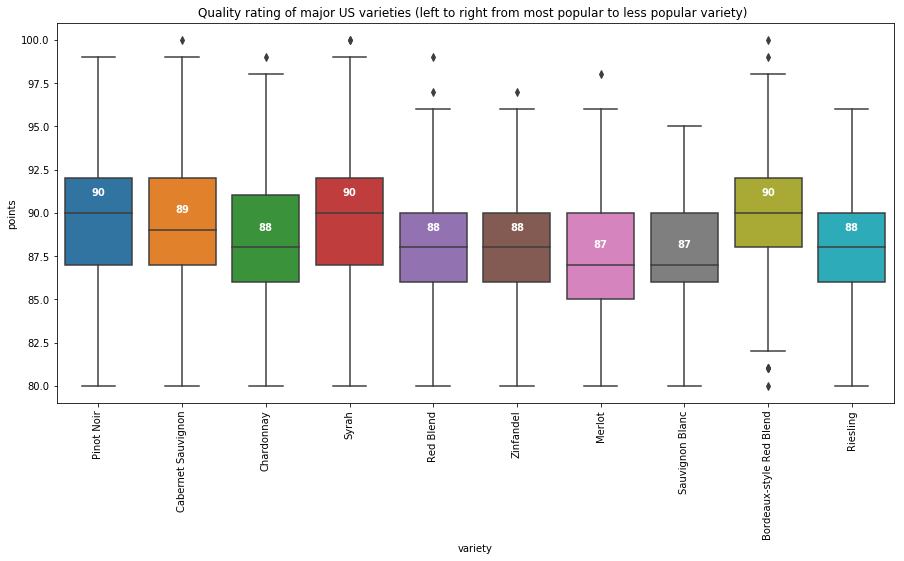

In [12]:
#create dataframe only with US wines
df = wine_groupped[wine_groupped['variety'].isin(variety_list)][wine_groupped['country']=='US']

#create boxplot with median number of points indicated
fig, ax = plt.subplots(figsize = (15,7))
chart = sns.boxplot(x='variety',y='points', data=df, ax = ax, order=variety_list)

medians = us['points'].values
median_labels = [str(int(s)) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 1.0, median_labels[tick], 
            horizontalalignment='center', size='medium', color='w', weight='semibold')
plt.xticks(rotation = 90)
plt.title("Quality rating of major US varieties (left to right from most popular to less popular variety) ")
plt.show()

In [16]:
#Create function that will determine 10 top wine varieties for a given country 
#and plot boxplot diagram of median points for these 10 varieties

def top_ten_varieties(df, country):  
    ''' Returns top ten most popular varieties by country'''
    
    country_data = df.loc[country_variety_counts['country']==country][:10]
    return country_data['variety'].values

def create_points_boxplot(df, country, n_varieties=10):
    
    '''Creates points boxplot 
    
    Input
    df: data frame
    country (str): country for which boxplot will be created
    n_varieties: number of varieties to plot
    
    
    Return: none'''
    country_data = country_variety_counts.loc[country_variety_counts['country']==country][:n_varieties]
    variety_list = country_data['variety'].values
    df = df[df['variety'].isin(variety_list)][df['country']==country]

    fig, ax = plt.subplots(figsize = (6,5))
    chart = sns.boxplot(x='variety',y='points', data=df, ax = ax, order=variety_list)

    medians = country_data['points'].values
    median_labels = [str(int(s)) for s in medians]

    pos = range(len(medians))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.3, median_labels[tick], 
                horizontalalignment='center', size='medium', color='black', weight='semibold')
    plt.xticks(rotation = 90)
    plt.title(country)
    plt.show()  

    


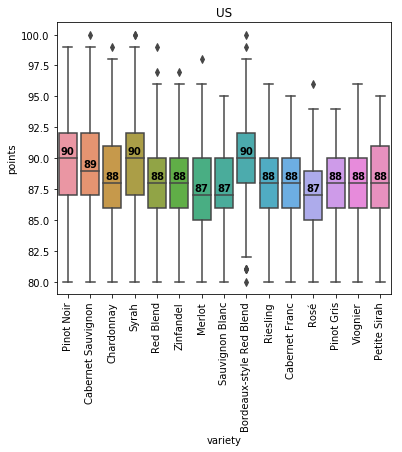

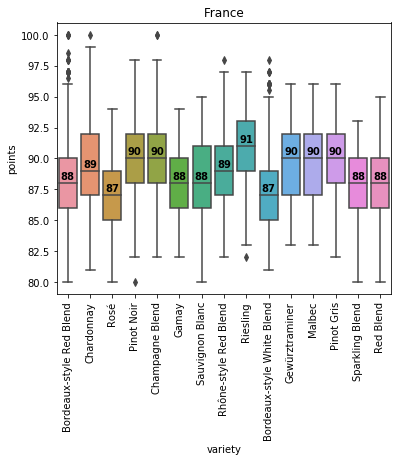

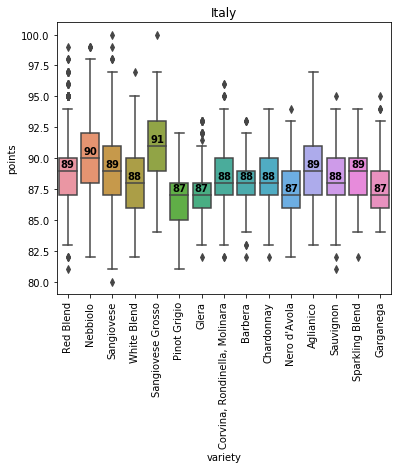

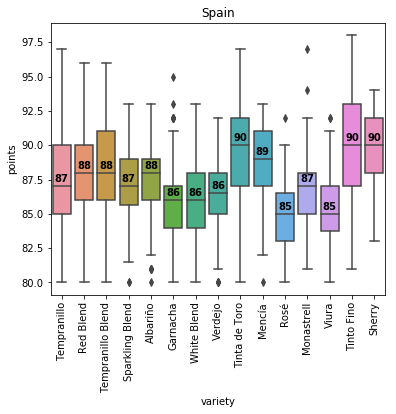

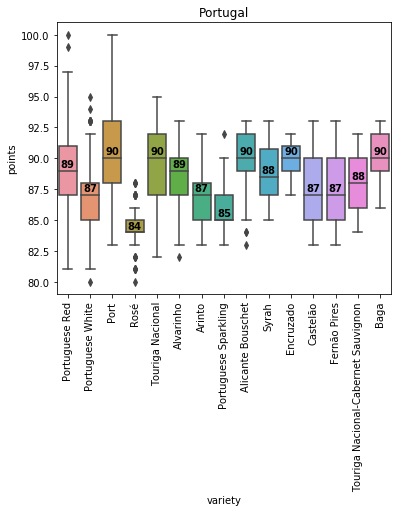

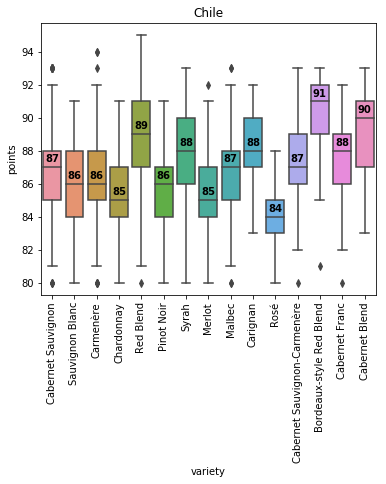

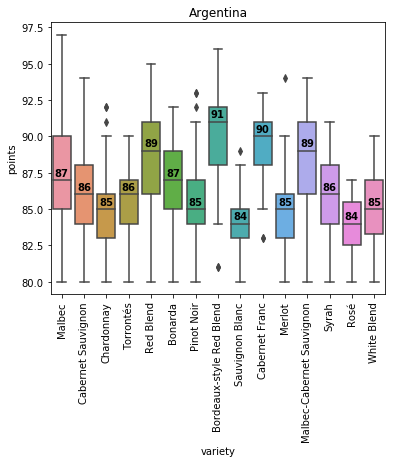

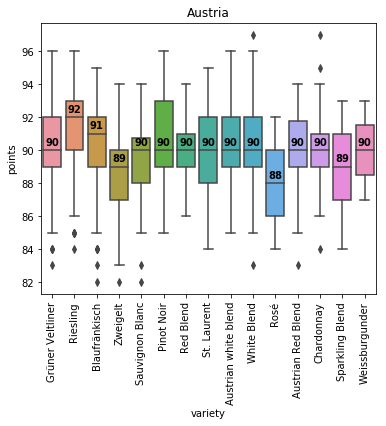

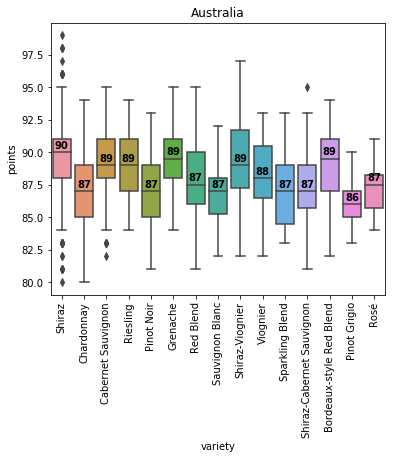

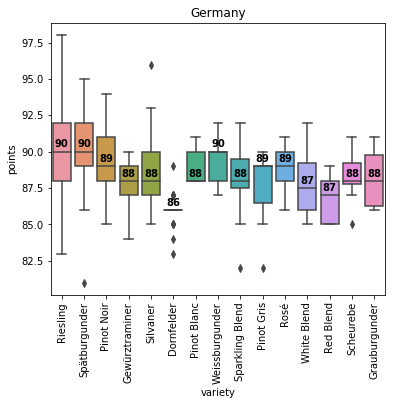

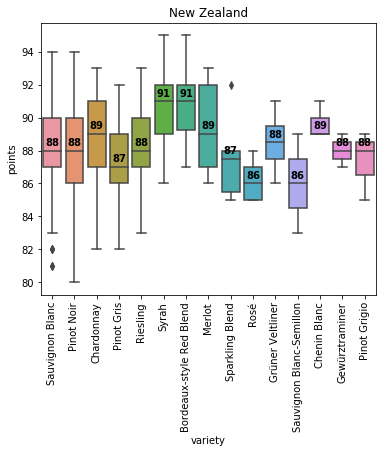

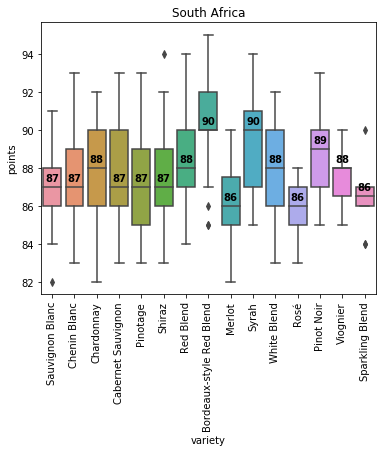

In [17]:
#Creates boxplot for 12 major countries with 12 most popular varieties 
#x axis from left to right from most popular to least popular
import warnings
warnings.filterwarnings('ignore')
for country in major_countries:
    create_points_boxplot(wine_groupped, country, 15)
     
    

### 2. What are the best rated wines in the different price category?###

Four categories will be considered:
    - $0-$15
    - $15-$50
    - $50-$150
    - >$150

Text(0.5,1,'Points vs Price')

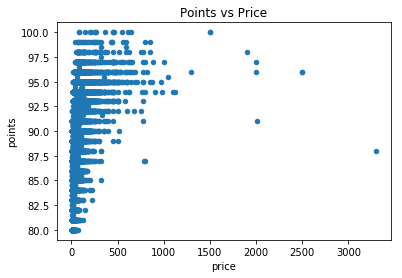

In [18]:
#create a scatter plot points vs price
wine_groupped.plot(kind='scatter', x = 'price', y= 'points')
plt.title("Points vs Price")

Text(0.5,1,'Points vs Price for 12 major countries')

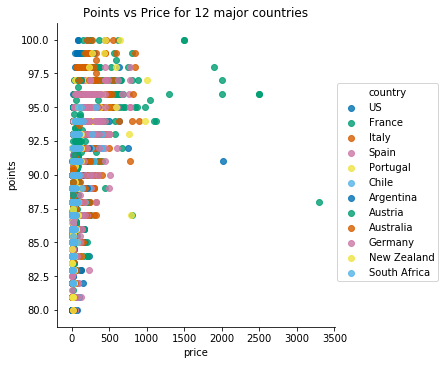

In [20]:
#similar but only for countries from major country list with hue=country
df = wine_groupped[wine_groupped['country'].isin(major_countries)]
sns.lmplot(x = 'price', y= 'points', hue_order = major_countries, 
           fit_reg=False, palette = sns.color_palette("colorblind"), data = df, hue="country", )
plt.title("Points vs Price for 12 major countries")

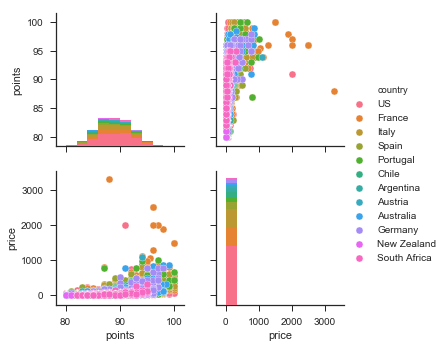

In [21]:
#create pairplot for continues features
sns.set(style="ticks")
sns.pairplot(df, hue_order = major_countries, hue="country" )

### Analysis for the price range 0 — 15 dollars ###

In [22]:
#create data frame only for the wines <$15
df1 = wine_groupped[wine_groupped['price']<15].sort_values(['points', 'price'], ascending=[False, True])
df1[['title','variety','country', 'province','points','price'] ][:15]


,title,variety,country,province,points,price
82418,Quinta dos Murças 2011 Assobio Red (Douro),Portuguese Red,Portugal,Douro,94.0,13.0
75027,Osborne NV Pedro Ximenez 1827 Sweet Sherry She...,Sherry,Spain,Andalucia,94.0,14.0
24111,Château d'Aydie 2010 Aydie l'Origine Tannat-Ca...,Tannat-Cabernet Franc,France,Southwest France,93.0,12.0
5711,Aveleda 2012 Follies Casa da Agueira Touriga N...,Touriga Nacional,Portugal,Bairrada,93.0,13.0
24026,Château Vincens 2011 Prestige Malbec-Merlot (C...,Malbec-Merlot,France,Southwest France,93.0,13.0
2198,Allram 2013 Hasel Alte Reben Reserve Grüner Ve...,Grüner Veltliner,Austria,Kamptal,93.0,14.0
48384,Gunter Triebaumer 2015 Furmint (Burgenland),Furmint,Austria,Burgenland,93.0,14.0
73885,Novy 2006 Oley Dessert Wine Viognier (Russian ...,Viognier,US,California,93.0,14.0
102044,Uvaggio 2009 Vermentino (Lodi),Vermentino,US,California,93.0,14.0
5706,Aveleda 2011 Follies Fonte Nossa Senhora da Va...,Touriga Nacional-Cabernet Sauvignon,Portugal,Bairrada,92.0,11.0


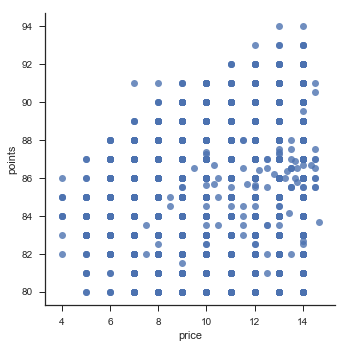

In [23]:
#scatter plot for wines <$15
sns.lmplot(x = 'price', y= 'points', fit_reg=False, data = df1)

### Analysis for the price range 15 — 50 dollars ###

In [24]:
#create data frame only for the wines $15<=price<$50
df2 = wine_groupped[wine_groupped['price']>=15][wine_groupped['price']<50].sort_values(['points', 'price'], ascending=[False, True])
df2[['title','variety','country', 'province','points','price'] ][:15]

,title,variety,country,province,points,price
40245,Failla 2010 Estate Vineyard Chardonnay (Sonoma...,Chardonnay,US,California,99.0,44.0
36038,Donkey & Goat 2010 Fenaughty Vineyard Syrah (E...,Syrah,US,California,97.0,35.0
96437,Taylor Fladgate NV 325 Anniversary (Port),Port,Portugal,Port,97.0,40.0
21482,Château Coutet 2014 Barsac,Bordeaux-style White Blend,France,Bordeaux,97.0,45.0
86770,Rulo 2007 Syrah (Columbia Valley (WA)),Syrah,US,Washington,96.0,20.0
36046,Donkey & Goat 2012 Grenache Noir Grenache (El ...,Grenache,US,California,96.0,27.0
52681,Isole e Olena 2010 Chianti Classico,Red Blend,Italy,Tuscany,96.0,27.0
98569,The Eyrie Vineyards 2014 Estate Chardonnay (Du...,Chardonnay,US,Oregon,96.0,27.0
21645,Château Filhot 2014 Sauternes,Bordeaux-style White Blend,France,Bordeaux,96.0,28.0
38362,Eichinger 2014 Gaisberg Reserve Riesling (Kamp...,Riesling,Austria,Kamptal,96.0,28.0


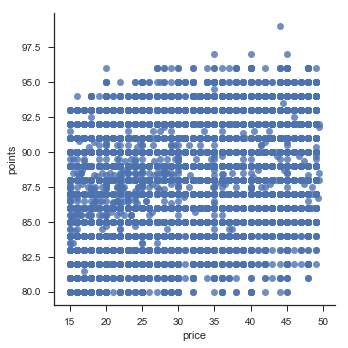

In [25]:
#scatter plot wines $15<=price<$50
sns.lmplot(x = 'price', y= 'points', fit_reg=False, data = df2)

### Analysis for the price range 50 — 150 dollars ###

In [29]:
#create data frame only for the wines $50<=price<$150
df3 = wine_groupped[wine_groupped['price']>=50][wine_groupped['price']<150].sort_values(['points', 'price'], ascending=[False, True])
df3[['title','variety','country', 'province','points','price'] ][:15]

,title,variety,country,province,points,price
18815,Cayuse 2008 Bionic Frog Syrah (Walla Walla Val...,Syrah,US,Washington,100.0,80.0
19861,Charles Smith 2006 Royal City Syrah (Columbia ...,Syrah,US,Washington,100.0,80.0
18828,Cayuse 2009 En Chamberlin Vineyard Syrah (Wall...,Syrah,US,Oregon,99.0,75.0
18847,Cayuse 2011 En Chamberlin Vineyard Syrah (Wall...,Syrah,US,Oregon,99.0,75.0
108015,Williams Selyem 2010 Hirsch Vineyard Pinot Noi...,Pinot Noir,US,California,99.0,75.0
107998,Williams Selyem 2009 Precious Mountain Vineyar...,Pinot Noir,US,California,99.0,94.0
100491,Trefethen 2005 Reserve Cabernet Sauvignon (Oak...,Cabernet Sauvignon,US,California,99.0,100.0
81421,Quilceda Creek 2008 Cabernet Sauvignon (Columb...,Cabernet Sauvignon,US,Washington,99.0,125.0
103027,Venge 2008 Family Reserve Cabernet Sauvignon (...,Cabernet Sauvignon,US,California,99.0,125.0
79100,Pirouette 2008 Red Wine Red (Columbia Valley (...,Bordeaux-style Red Blend,US,Washington,98.0,50.0


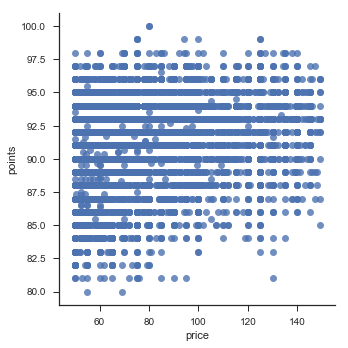

In [30]:
#scatter plot wines $50<=price<$150
sns.lmplot(x = 'price', y= 'points', fit_reg=False, data = df3)

### Analysis for the higher than 150 dollars ###

In [31]:
#create data frame only for the wines with price >$150
df4 = wine_groupped[wine_groupped['price']>=150].sort_values(['points', 'price'], ascending=[False, True])
df4[['title','variety','country', 'province','points','price'] ][:15]

,title,variety,country,province,points,price
22743,Château Léoville Barton 2010 Saint-Julien,Bordeaux-style Red Blend,France,Bordeaux,100.0,150.0
15851,Cardinale 2006 Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,US,California,100.0,200.0
5802,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Italy,Tuscany,100.0,210.0
63669,Louis Roederer 2008 Cristal Vintage Brut (Cha...,Champagne Blend,France,Champagne,100.0,250.0
57763,Krug 2002 Brut (Champagne),Champagne Blend,France,Champagne,100.0,259.0
17003,Casanova di Neri 2007 Cerretalto (Brunello di...,Sangiovese Grosso,Italy,Tuscany,100.0,270.0
22750,Château Léoville Las Cases 2010 Saint-Julien,Bordeaux-style Red Blend,France,Bordeaux,100.0,359.0
16479,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Portugal,Douro,100.0,450.0
103334,Verité 2007 La Muse Red (Sonoma County),Bordeaux-style Red Blend,US,California,100.0,450.0
97188,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Italy,Tuscany,100.0,460.0


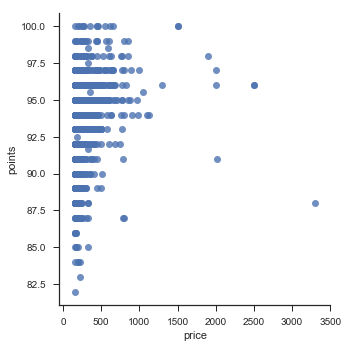

In [32]:
#scatter plot for wines with price>$150
sns.lmplot(x = 'price', y= 'points', fit_reg=False, data = df4)

### 3. What is the most common description for the best rated wines produced in different countries?###

In [34]:
def obtain_coutry_description(country):    
    '''obtain description list for the best rated wines (>87 points)
    Input
    country (str): country
    
    Return: description list
    '''
    
    mean_points_value = wine_groupped['points'].mean()
    remove_characters = re.compile('[^A-Za-z ]+')
    
    description_list = list(wine_groupped[wine_groupped['country']==country][wine_groupped['points']>mean_points_value]['description'])
    flat_list = [re.sub(remove_characters, ' ', item) for sublist in description_list for item in sublist]
    description = ' '.join(flat_list)
    return description


In [35]:
def plot_country_wordcloud(words, country_mask, out_image_name):
    '''creates word cloud image
    
    Input
    words (list): list with description for country
    country_mask (str): path to jpg image
    out_image_name (str): path to output image
    
    Return: wordcloud object
    '''
    
    stopwords = ['now','nose','aroma', 'aromas', 'selection', 'drink','wine','wines','come','add','give', 'come',
                 'flavor','flavors','one', 'bottle','bottling','made','almost','note','notes','palate','finish',
                 'hint','hints','show','shows','open', 'now', 'offering', 'almost', 'winery', 'making', 'lot', 
                 'along', 'offer', 'make', 'offers', 'yet']
    for w in stopwords:
        STOPWORDS.add(w)
        
    maska = np.array(Image.open(country_mask))
    wc = WordCloud(background_color="white", mask=maska, max_words=2000, random_state=42, 
                   stopwords=STOPWORDS, colormap = 'hsv')
    wc.generate(words)
    wc.to_file(out_image_name)
    
    return wc


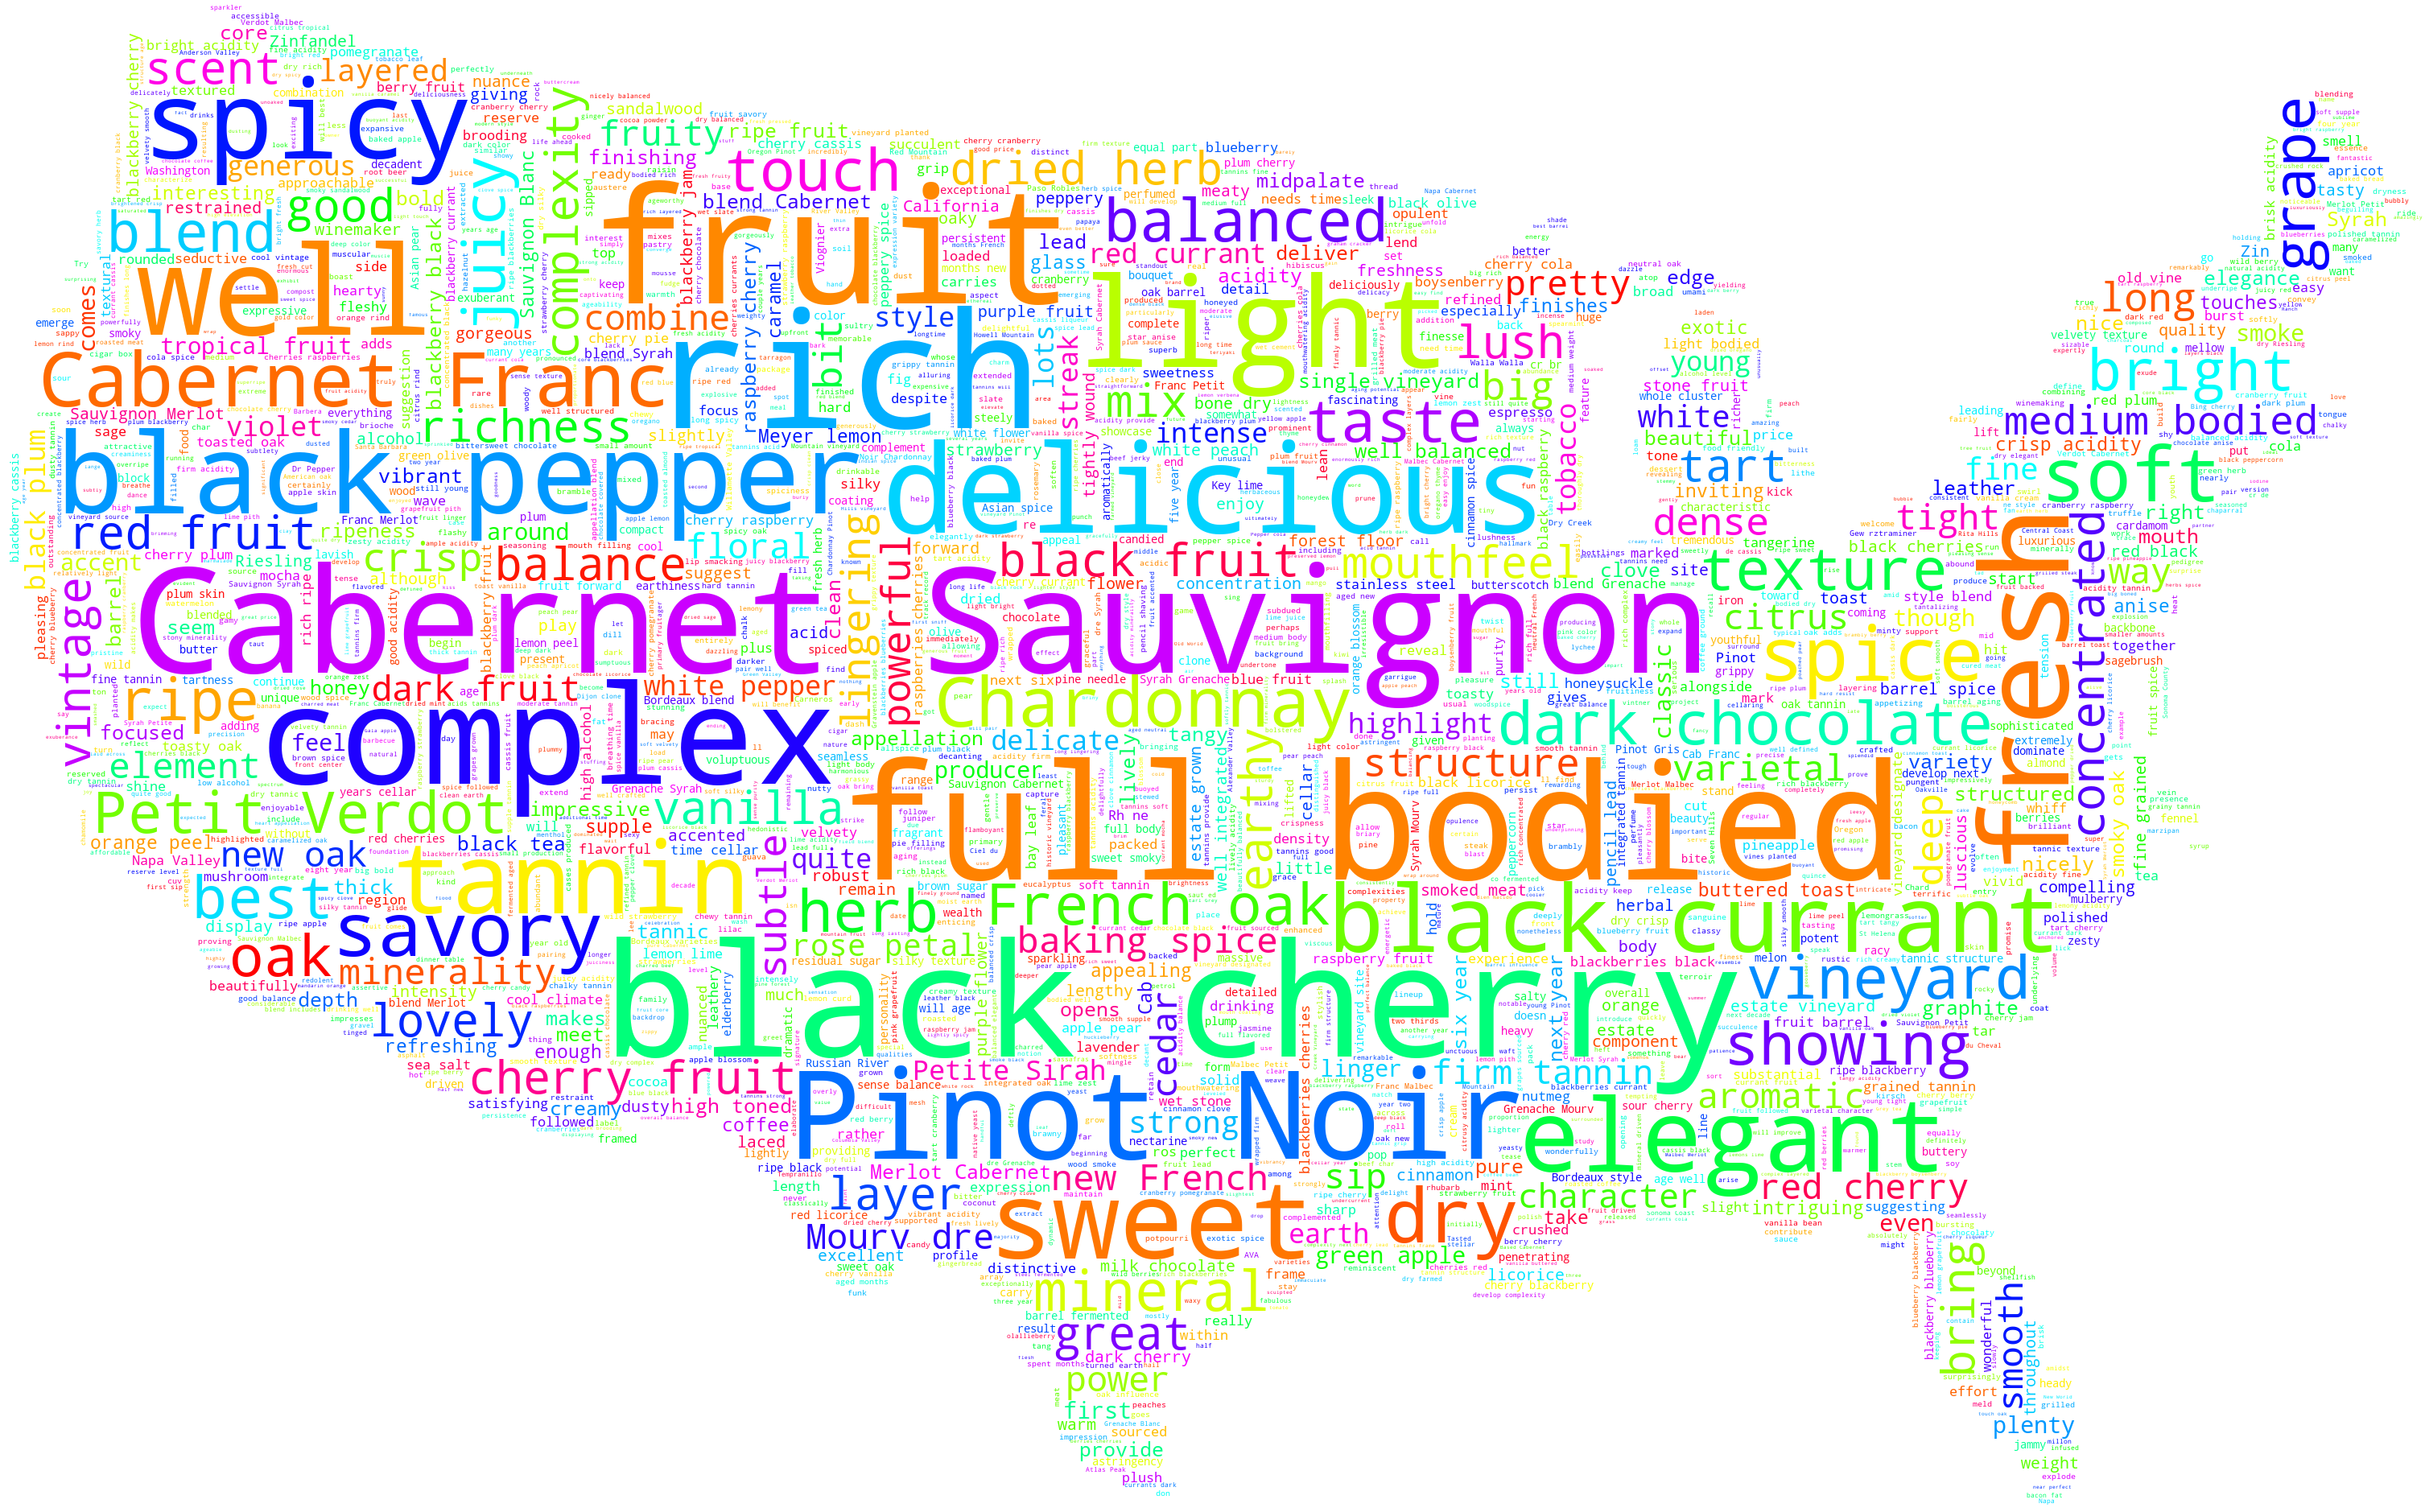

In [36]:
#try it on US
US_mask = './Masks/united-states-silhouette.jpg'
us_description = obtain_coutry_description("US")
us_wc = plot_country_wordcloud(us_description, US_mask, './WineWordcloud/US.pdf')
us_wc.to_image()



In [37]:
#create dictionary of mask images
mask_images = {}
mask_images["US"] = './Masks/united-states-silhouette.jpg'
mask_images["France"] = './Masks/france-silhouette.jpg'
mask_images["Italy"] = './Masks/italy-silhouette.jpg'
mask_images["Spain"] = './Masks/spain-silhouette.jpg'
mask_images["South Africa"] = './Masks/south-africa-silhouette.jpg'
mask_images["New Zealand"] = './Masks/new-zealand-silhouette.jpg'
mask_images["Germany"] = './Masks/germany-silhouette.jpg'
mask_images["Argentina"] = './Masks/argentina-silhouette.jpg'
mask_images["Australia"] = './Masks/australia-silhouette.jpg'
mask_images["Austria"] = './Masks/austria-silhouette.jpg'
mask_images["Chile"] = './Masks/chile-silhouette.jpg'
mask_images["Portugal"] = './Masks/portugal-silhouette.jpg'

In [38]:
#create wine wordcloud images for 12 major countries
for country in major_countries:
    print(country)
    description = obtain_coutry_description(country)
    image_name = './WineWordcloud/' + '_'.join(country.split()) + '.pdf'
    print(image_name)
    wc = plot_country_wordcloud(description, mask_images[country], image_name )
    wc.to_image()
    

US
./WineWordcloud/US.pdf
France
./WineWordcloud/France.pdf
Italy
./WineWordcloud/Italy.pdf
Spain
./WineWordcloud/Spain.pdf
Portugal
./WineWordcloud/Portugal.pdf
Chile
./WineWordcloud/Chile.pdf
Argentina
./WineWordcloud/Argentina.pdf
Austria
./WineWordcloud/Austria.pdf
Australia
./WineWordcloud/Australia.pdf
Germany
./WineWordcloud/Germany.pdf
New Zealand
./WineWordcloud/New_Zealand.pdf
South Africa
./WineWordcloud/South_Africa.pdf


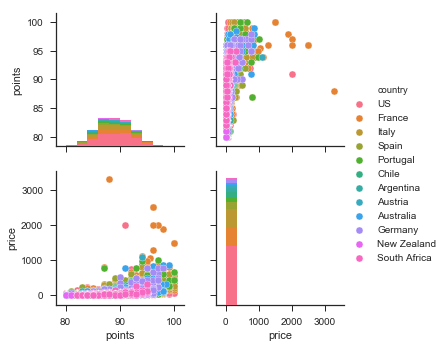

In [39]:
#creates scatter plot numerical features for 12 major countries with hue=country
df = wine_groupped[wine_groupped['country'].isin(major_countries)]
sns.set(style="ticks")
sns.pairplot(df, hue_order = major_countries, hue="country" )